In [1]:
pip install google-adk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: cachetools
    Found existing installation: cachetools 6.2.1
    Uninstalling cachetools-6.2.1:
      Successfully uninstalled cachetools-6.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.

# Geminis API key

In [2]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error. Details: {e}"
    )

Gemini API key setup complete.


In [3]:
from google.adk.agents import Agent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import google_search
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


Below code not required outside kaggle

In [4]:
from IPython.core.display import display, HTML
from jupyter_server.serverapp import list_running_servers



def get_adk_proxy_url():
    PROXY_HOST = "https://kkb-production.jupyter-proxy.kaggle.net"
    ADK_PORT = "8000"

    servers = list(list_running_servers())
    if not servers:
        raise Exception("No running Jupyter servers found.")

    baseURL = servers[0]["base_url"]

    try:
        path_parts = baseURL.split("/")
        kernel = path_parts[2]
        token = path_parts[3]
    except IndexError:
        raise Exception(f"Could not parse kernel/token from base URL: {baseURL}")

    url_prefix = f"/k/{kernel}/{token}/proxy/proxy/{ADK_PORT}"
    url = f"{PROXY_HOST}{url_prefix}"

    styled_html = f"""
    <div style="padding: 15px; border: 2px solid #f0ad4e; border-radius: 8px; background-color: #fef9f0; margin: 20px 0;">
        <div style="font-family: sans-serif; margin-bottom: 12px; color: #333; font-size: 1.1em;">
            <strong>⚠️ IMPORTANT: Action Required</strong>
        </div>
        <div style="font-family: sans-serif; margin-bottom: 15px; color: #333; line-height: 1.5;">
            The ADK web UI is <strong>not running yet</strong>. You must start it in the next cell.
            <ol style="margin-top: 10px; padding-left: 20px;">
                <li style="margin-bottom: 5px;"><strong>Run the next cell</strong> (the one with <code>!adk web ...</code>) to start the ADK web UI.</li>
                <li style="margin-bottom: 5px;">Wait for that cell to show it is "Running" (it will not "complete").</li>
                <li>Once it's running, <strong>return to this button</strong> and click it to open the UI.</li>
            </ol>
            <em style="font-size: 0.9em; color: #555;">(If you click the button before running the next cell, you will get a 500 error.)</em>
        </div>
        <a href='{url}' target='_blank' style="
            display: inline-block; background-color: #1a73e8; color: white; padding: 10px 20px;
            text-decoration: none; border-radius: 25px; font-family: sans-serif; font-weight: 500;
            box-shadow: 0 2px 5px rgba(0,0,0,0.2); transition: all 0.2s ease;">
            Open ADK Web UI (after running cell below) ↗
        </a>
    </div>
    """

    display(HTML(styled_html))

    return url_prefix


print("✅ Helper functions defined.")

✅ Helper functions defined.


Retry config: fixes rate limits or service unavailable

In [5]:
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1, # Initial delay before first retry (in seconds)
    http_status_codes=[429, 500, 503, 504] # Retry on these HTTP errors
)

# AI Agent with ADK
> Prompt -> Agent -> Thought -> Action -> Observation -> Final Answer

## Properties
name and description: A simple name and description to identify our agent.


model: The specific LLM that will power the agent's reasoning. We'll use "gemini-2.5-flash-lite


instruction: The agent's guiding prompt. This tells the agent what its goal is and how to behave.


tools: A list of tools that the agent can use. To start, we'll give it the google_search tool, which lets it find up-to-date information online.


In [6]:
root_agent = Agent(
    name="gemini",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="simple agent .",
    instruction="Use Google Search for current info or if unsure.",
    tools=[google_search],
)

print("Root Agent defined.")

Root Agent defined.


Run agent

In [7]:
runner = InMemoryRunner(agent=root_agent)

print("✅ Runner created.")

✅ Runner created.


.run_debug() to send prompt and get an answer
The agent inspects and is aware of which tools it has available to use.
The agent's instructions specify the use of the search tool to get current information or if it is unsure of an answer.

In [8]:
response = await runner.run_debug(
    "Hey are you working? Say hi to everyone"
)


 ### Created new session: debug_session_id

User > Hey are you working? Say hi to everyone
gemini > Hi everyone! Yes, I am working and ready to help.


In [9]:
response = await runner.run_debug("Say hi again")


 ### Continue session: debug_session_id

User > Say hi again
gemini > Hi again! How can I assist you today?


# ADK web interface

In [10]:
!adk create sample-agent --model gemini-2.5-flash-lite --api_key $GOOGLE_API_KEY


Agent created in /kaggle/working/sample-agent:
- .env
- __init__.py
- agent.py



# # RUN:
!adk web --url_prefix {url_prefix}

url_prefix = get_adk_proxy_url()

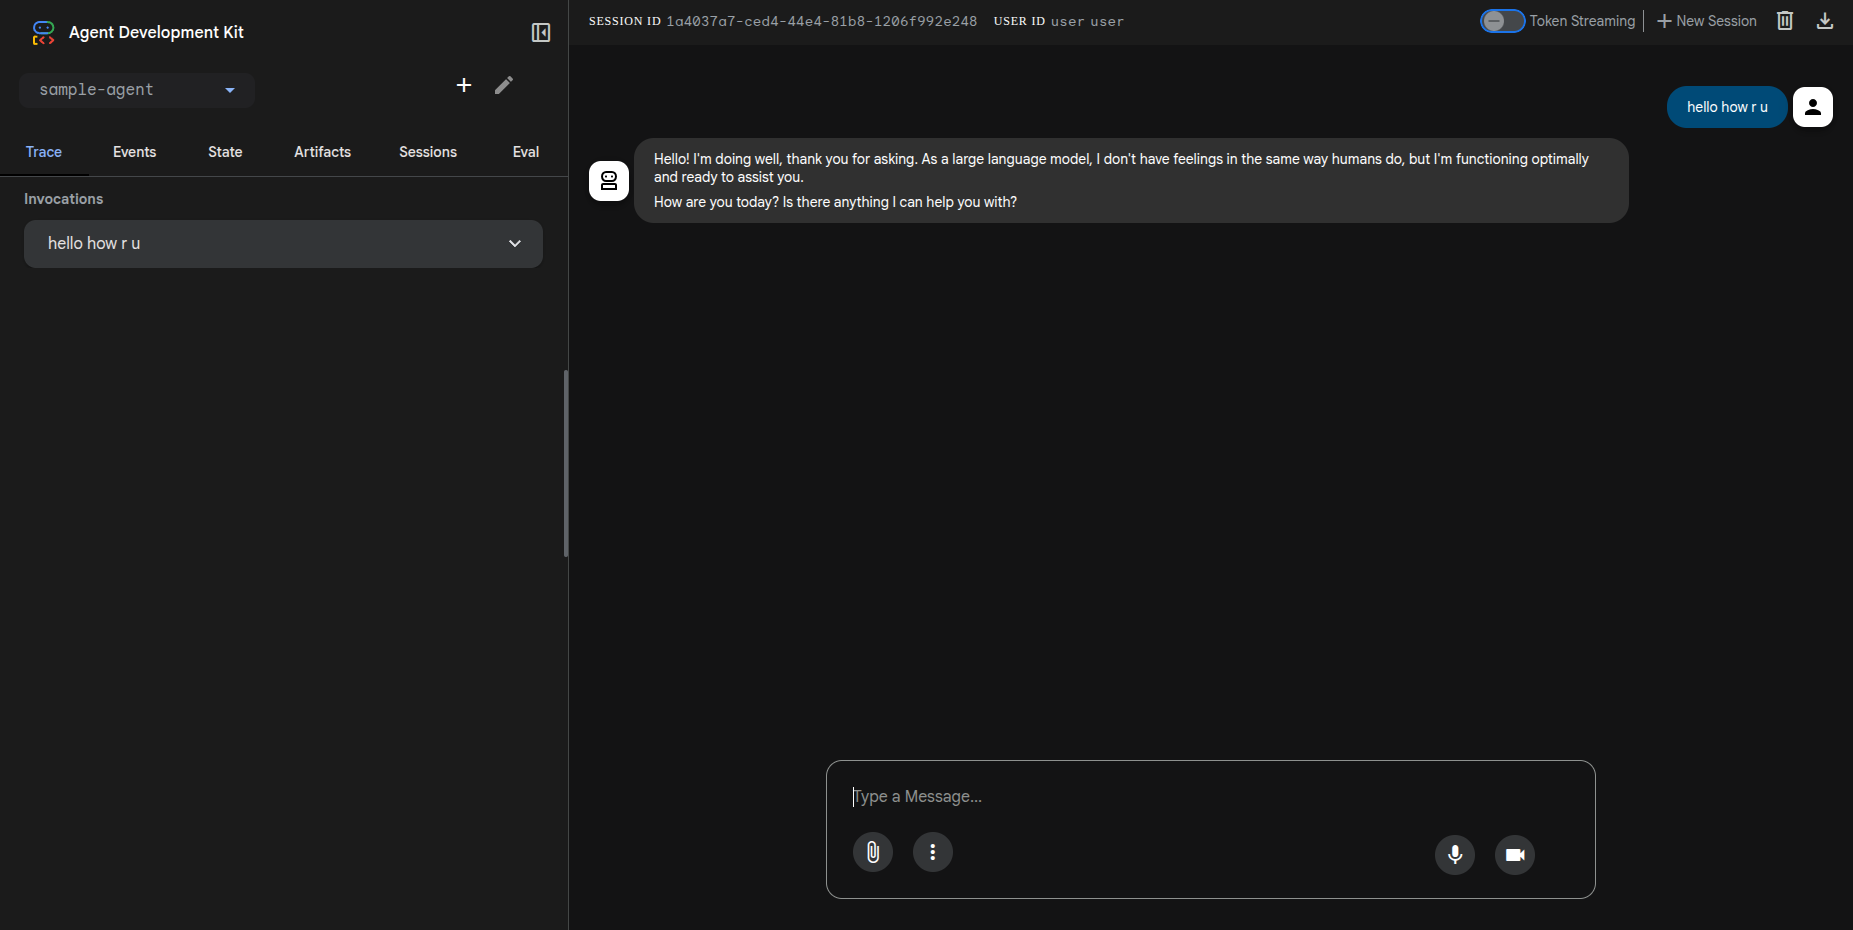
